In [1]:
import sys
sys.path.append("../")
sys.path.append("../diffusion")

import utils
import guidance
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
from torch_geometric.data import Data
import pickle

DEVICE = "cuda:0"

def plot_set(data_set, nrows = 3, ncols = 6, scale_factor = 1.0):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(scale_factor*ncols*2, scale_factor*nrows*2)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        ax = axes[i//ncols][i%ncols] if nrows > 1 else axes[i%ncols]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def preprocess_placement(x, cond, scale=1):
    if len(cond.chip_size) == 4: # chip_size is [x_start, y_start, x_end, y_end]
        chip_size = (cond.chip_size[2] - cond.chip_size[0], cond.chip_size[3] - cond.chip_size[1])
        chip_offset = (cond.chip_size[0], cond.chip_size[1])
    else:
        chip_size = (cond.chip_size[0], cond.chip_size[1])
        chip_offset = (0, 0)
    chip_size = torch.tensor(chip_size, dtype = torch.float32).view(1, 2)
    chip_offset = torch.tensor(chip_offset, dtype = torch.float32).view(1, 2)
    x = (torch.tensor(x, dtype=torch.float32) - chip_offset)/scale
    x = 2 * (x / chip_size) - 1
    # use center of instance as coordinate point and reference for terminal
    x = x + cond.x/2
    return x

def eval_set(data_set, eval_fn, **kwargs):
    return [eval_fn(x, cond, normalized_hpwl=False, **kwargs)[1] for (x, cond) in data_set]

def plot_and_eval_set(data_set, eval_fn, nrows = 3, ncols = 6, scale_factor = 1.0, title=None):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(scale_factor*ncols*2, scale_factor*nrows*2 + 0.2)
    if title:
        fig.suptitle(title)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        ax = axes[i//ncols][i%ncols] if nrows > 1 else axes[i%ncols]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        metric = eval_fn(x, cond, normalized_hpwl=False)[1]
        ax.set_title(f"{metric:.0f}")
    plt.show()

## Inspecting Benchmarks

### ISPD

Train set and val set sizes:  0 4


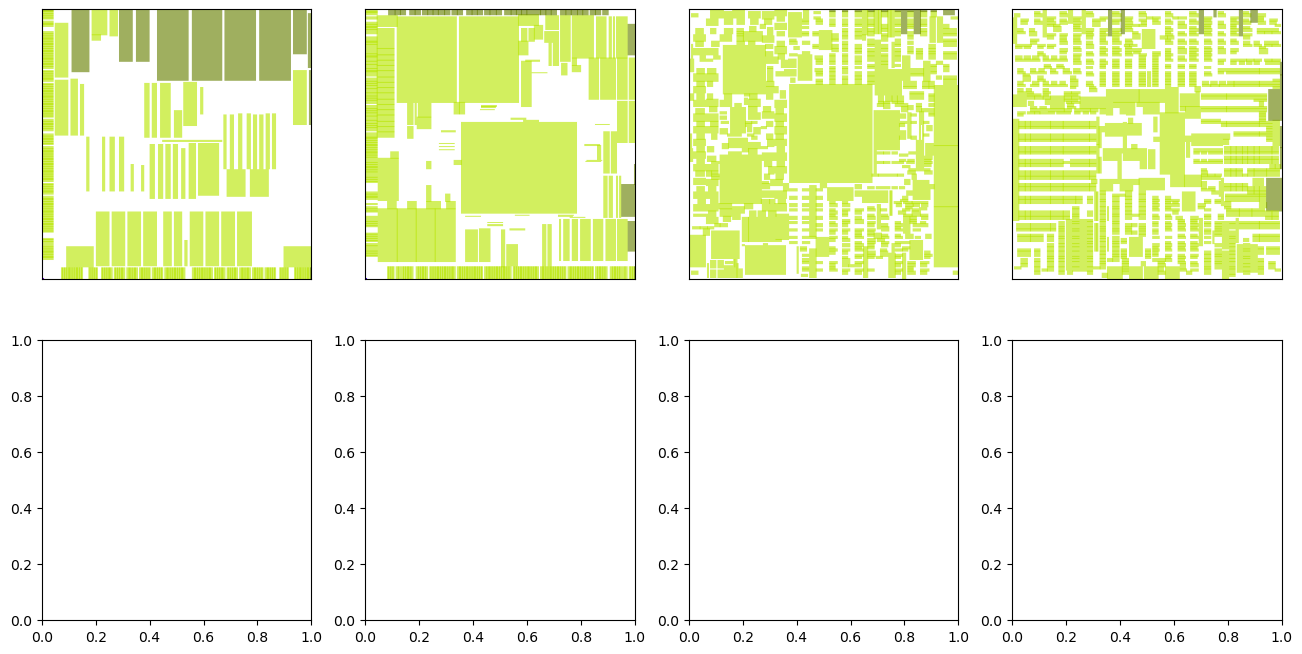

# objects: [211447, 255023, 451650, 496045]
# edges: [1445822, 1606946, 2816562, 2792938]
# macros: [543, 566, 723, 1329]
# ports: [0, 0, 0, 0]
Data(x=[211447, 2], edge_index=[2, 1445822], edge_attr=[1445822, 4], is_ports=[211447], is_macros=[211447], edge_pin_id=[1445822, 2], chip_size=[4], file_idx=0)


In [52]:
task = "ispd2005-v5"
train_set, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = 4,
    )

print("Train set and val set sizes: ", len(train_set), len(val_set))
plot_set(val_set, nrows=2, ncols=4, scale_factor=2)

num_objects = [cond.num_nodes for (x, cond) in val_set]
num_edges = [cond.num_edges for (x, cond) in val_set]
num_macros = [cond.is_macros.sum().cpu().item() for (x, cond) in val_set]
num_ports = [cond.is_ports.sum().cpu().item() for (x, cond) in val_set]
print("# objects:", num_objects)
print("# edges:", num_edges)
print("# macros:", num_macros)
print("# ports:", num_ports)
print(val_set[0][1])

In [53]:
print([cond.chip_size for (x, cond) in val_set])

[[0.459, 0.459, 11.151, 11.139], [0.609, 0.616, 14.663, 14.655999999999999], [0.036, 0.058, 23.226000000000003, 23.386], [0.036, 0.058, 23.226000000000003, 23.386]]


In [47]:
# replace chip_size and save to new dir
print([cond.chip_size for (x, cond) in val_set])
ispd_chip_sizes = {
    0: [0.459, 0.459, 0.459 + 10692/1000, 0.459 + 12*890/1000], # adaptec1
    1: [0.609, 0.616, 0.609 + 14054/1000, 0.616 + 12*1170/1000],
    2: [0.036, 0.058, 0.036 + 23190/1000, 23386/1000],
    3: [0.036, 0.058, 0.036 + 23190/1000, 23386/1000],
    4: [0.459, 0.459, 0.459 + 10692/1000, 11139/1000], # bigblue1 
    5: [0.036, 0.076, 0.036 + 18690/1000, 18868/1000],
    6: [0.036, 0.076, 0.036 + 27690/1000, 27868/1000],
    7: [0.036, 0.058, 0.036 + 32190/1000, 32386/1000],
}

output_dir = "../datasets/graph/ispd2005-v5"
for (x, cond) in val_set:
    cond.chip_size = ispd_chip_sizes.get(cond.file_idx, cond.chip_size)
    x, cond = utils.postprocess_placement(x, cond, process_graph=True)

    cond_path = os.path.join(output_dir, f"graph{cond.file_idx}.pickle")
    x_path = os.path.join(output_dir, f"output{cond.file_idx}.pickle")
    
    with open(cond_path, 'wb') as f:
        pickle.dump(cond, f)
    with open(x_path, 'wb') as f:
        pickle.dump(x, f)
    print(f"saved graph to {cond_path} and placement to {x_path}")

[[0.0, 0.0, 10.692, 10.68]]
saved graph to ../datasets/graph/ispd2005-v5/graph0.pickle and placement to ../datasets/graph/ispd2005-v5/output0.pickle


### TILOS

Train set and val set sizes:  0 4


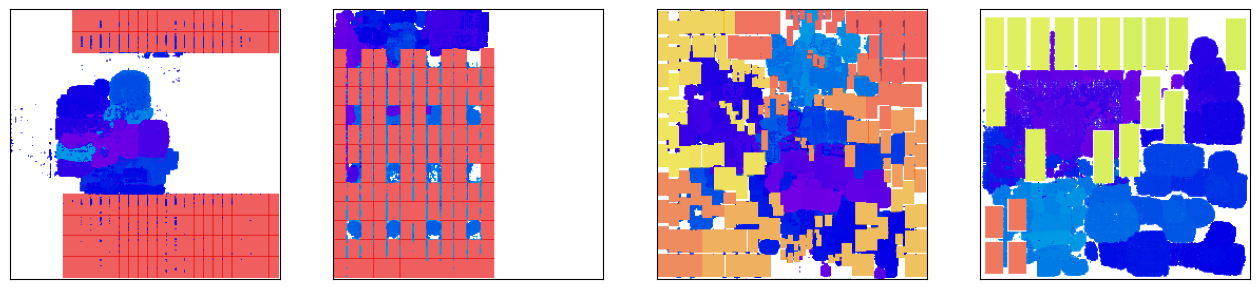

# objects: [122489, 154479, 714980, 129663]
# edges: [692450, 914588, 3899080, 694772]
# macros: [136, 128, 220, 20]
# ports: [495, 797, 42, 1148]
Data(x=[122489, 2], edge_index=[2, 692450], edge_attr=[692450, 4], is_ports=[122489], is_macros=[122489], chip_size=[4], file_idx=1)


In [3]:
task = "tilos"
train_set, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = None,
    )

# val_set = [(x[0], cond) for x, cond in val_set]
print("Train set and val set sizes: ", len(train_set), len(val_set))
plot_set(val_set, nrows=1, ncols=4, scale_factor=2)

num_objects = [cond.num_nodes for (x, cond) in val_set]
num_edges = [cond.num_edges for (x, cond) in val_set]
num_macros = [cond.is_macros.sum().cpu().item() for (x, cond) in val_set]
num_ports = [cond.is_ports.sum().cpu().item() for (x, cond) in val_set]
print("# objects:", num_objects)
print("# edges:", num_edges)
print("# macros:", num_macros)
print("# ports:", num_ports)
print(val_set[0][1])

### ISPD - Macro-only Placement

Train set and val set sizes:  0 4
cuda:0 cuda:0
# objects: [211447, 255023, 451650, 496045]
# objects in placement: [211447, 255023, 451650, 496045]
# edges: [1445822, 1606946, 2816562, 2792938]
# macros: [543, 566, 723, 1329]
# ports: [0, 0, 0, 0]
Data(x=[211447, 2], edge_index=[2, 1445822], edge_attr=[1445822, 4], is_ports=[211447], is_macros=[211447], edge_pin_id=[1445822, 2], chip_size=[4], file_idx=0)


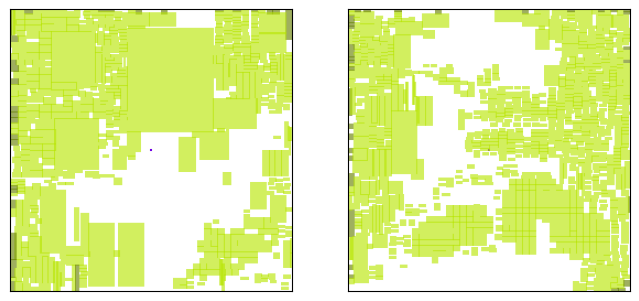

In [ ]:
task = "ispd2005-v5"
placement_dir = "../logs/diffusion_debug/ispd2005-v5m.eval_guided.100/samples"
train_set, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = None,
    )

print("Train set and val set sizes: ", len(train_set), len(val_set))

placement_paths = [os.path.join(placement_dir, f"sample{cond.file_idx}.pkl") for _, cond in val_set]
placements = [preprocess_placement(utils.open_pickle(path), cond) for path, (_, cond) in zip(placement_paths, val_set)]

placed_set = [(x.to(device=DEVICE), cond.to(device=DEVICE)) for x, (_, cond) in zip(placements, val_set)]
print(placed_set[0][0].device, placed_set[0][1].x.device)

num_objects = [cond.num_nodes for (x, cond) in val_set]
num_placement_objects = [x.shape[0] for (x, cond) in val_set]
num_edges = [cond.num_edges for (x, cond) in val_set]
num_macros = [cond.is_macros.sum().cpu().item() for (x, cond) in val_set]
num_ports = [cond.is_ports.sum().cpu().item() for (x, cond) in val_set]
print("# objects:", num_objects)
print("# objects in placement:", num_placement_objects)
print("# edges:", num_edges)
print("# macros:", num_macros)
print("# ports:", num_ports)
print(val_set[0][1])

plot_set(placed_set, nrows=2, ncols=4, scale_factor=2)

## Clustering

In [21]:
num_clusters = 512
print(f"Clustering {task} into {num_clusters} clusters")

output_dir = "../datasets/graph/tilos-cluster512"
for (x, cond) in val_set:
    # Movable ports
    cond.is_ports = torch.zeros_like(cond.is_ports)
    # TODO fix pin id generation for tilos
    cond, x = utils.cluster(cond, num_clusters = num_clusters, placements = x.unsqueeze(dim=0), shmetis_dir = "..")
    x, cond = utils.postprocess_placement(x[0], cond, process_graph=True)

    cond_path = os.path.join(output_dir, f"graph{cond.file_idx}.pickle")
    x_path = os.path.join(output_dir, f"output{cond.file_idx}.pickle")
    
    with open(cond_path, 'wb') as f:
        pickle.dump(cond, f)
    with open(x_path, 'wb') as f:
        pickle.dump(x, f)
    print(f"saved graph to {cond_path} and placement to {x_path}")

Clustering tilos into 512 clusters
saved graph to ../datasets/graph/tilos-cluster512/graph1.pickle and placement to ../datasets/graph/tilos-cluster512/output1.pickle
saved graph to ../datasets/graph/tilos-cluster512/graph2.pickle and placement to ../datasets/graph/tilos-cluster512/output2.pickle
saved graph to ../datasets/graph/tilos-cluster512/graph3.pickle and placement to ../datasets/graph/tilos-cluster512/output3.pickle
saved graph to ../datasets/graph/tilos-cluster512/graph4.pickle and placement to ../datasets/graph/tilos-cluster512/output4.pickle


In [10]:
print(cond)
print(cond.x)
print(cond.x.max())
print(cond.is_macros.sum())
print(x.shape)

Data(x=[1143, 2], edge_index=[2, 305430], edge_attr=[305430, 4], is_ports=[1143], is_macros=[1143], cluster_map=[122489], chip_size=[4], file_idx=1)
tensor([[0.0253, 0.0253],
        [0.0240, 0.0240],
        [0.0233, 0.0233],
        ...,
        [0.0012, 0.0012],
        [0.0012, 0.0012],
        [0.0012, 0.0012]])
tensor(0.1547)
tensor(136)
torch.Size([1, 1143, 2])
